# Go faster: numba and multiprocessing

*Davide Gerosa (Milano-Bicocca)*

**Sources**: The data frog: https://thedatafrog.com/en/articles/make-python-fast-numba 

**Sources**: my own research

Today we look into two complementary strategies to speed up python.

Note the scaling is not perfectly linear, because there's an overhead when spawning new processes

# Exercises

For the exame prepare two of these exercises.

## Q1: The stock market

(This is about numba)

A Markov Chain is defined as a sequence of random variables where a parameter depends *only* on the preceding value. This is a crucial tool in statistics, widely used in science and beyond (economics for instance).

For instance, the stock market has phases of growing prices (bull), dreasing prices (bear) and recession. This would be a Marov Chain model:

![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Finance_Markov_chain_example_state_space.svg/400px-Finance_Markov_chain_example_state_space.svg.png)

where the numbers on the arrows indicate the probabily that the next day will be in a given state.

Your task is to simulate the stock market according to this rule. Start from a random state and simulate many many  iterations. If your code is right, the fraction of days in each state should converge. 

Implement a pure-python version and a numba version, and compare speeds. 


In [73]:
import numpy as np
from numba import njit
from time import time, sleep
import matplotlib.pyplot as plt

In [74]:
states = ("stagnant", "bull", "bear")
n_states = np.array(("stagnant", "bull", "bear"))


def next(state):
    rand = np.random.rand()
    if state == "stagnant":
        return np.random.choice(states, p=[0.5, 0.25, 0.25])
    elif state == "bull":
        return np.random.choice(states, p=[0.025, 0.9, 0.075])
    return np.random.choice(states, p=[0.05, 0.15, 0.8])


def simulate(iterations=10000):
    days = {state: 0 for state in states}
    state = np.random.choice(states)

    for _ in range(iterations):
        state = next(state)
        days[state] += 1

    
    return {k:v/iterations for k, v in days.items()}

@njit
def n_next(state):
    if state == "stagnant":
        p=np.asarray([0.5, 0.25, 0.25])
        return states[np.searchsorted(np.cumsum(p), np.random.rand(1))[0]]
    elif state == "bull":
        p=np.asarray([0.025, 0.9, 0.075])
        return states[np.searchsorted(np.cumsum(p), np.random.rand(1))[0]]
    p=np.asarray([0.05, 0.15, 0.8])
    return states[np.searchsorted(np.cumsum(p), np.random.rand(1))[0]]

@njit
def n_simulate(iterations=10000):
    days = {state: 0 for state in n_states}
    state = np.random.choice(n_states)

    for _ in range(iterations):
        state = n_next(state)
        days[state] += 1

    
    return {k:v/iterations for k, v in days.items()}


Iterations 10
{'stagnant': 0.0, 'bull': 0.9, 'bear': 0.1}
{'stagnant': 0.2, 'bull': 0.8, 'bear': 0.0}

Iterations 100
{'stagnant': 0.02, 'bull': 0.75, 'bear': 0.23}
{'stagnant': 0.08, 'bull': 0.6, 'bear': 0.32}

Iterations 1000
{'stagnant': 0.053, 'bull': 0.653, 'bear': 0.294}
{'stagnant': 0.084, 'bull': 0.608, 'bear': 0.308}

Iterations 10000
{'stagnant': 0.0588, 'bull': 0.6149, 'bear': 0.3263}
{'stagnant': 0.0652, 'bull': 0.6175, 'bear': 0.3173}

Iterations 100000
{'stagnant': 0.06324, 'bull': 0.62304, 'bear': 0.31372}
{'stagnant': 0.06334, 'bull': 0.6159, 'bear': 0.32076}

Iterations 1000000
{'stagnant': 0.062548, 'bull': 0.622986, 'bear': 0.314466}
{'stagnant': 0.062486, 'bull': 0.626411, 'bear': 0.311103}


Text(0, 0.5, 'Time required for simulation [s]')

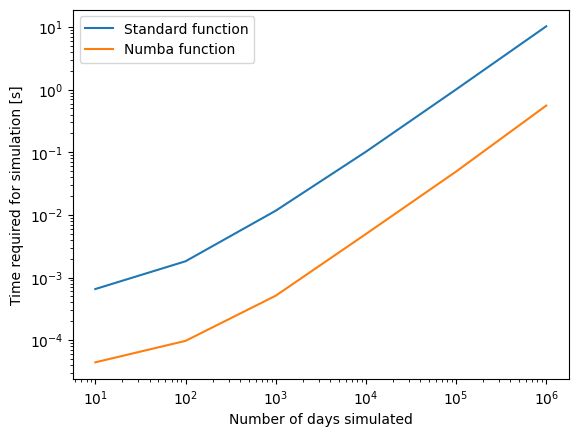

In [85]:
std_time = []
numba_time = []

exp = 6

x = np.logspace(1, exp, exp).astype(int)

for i in x:
    print(f"\nIterations {i}")
    
    start = time()
    a = simulate(i)
    std_time.append(time() - start)
    print(dict(a))
    
    start = time()
    a = n_simulate(i)
    numba_time.append(time() - start)
    print(dict(a))

plt.plot(x, std_time, label="Standard function")
plt.plot(x, numba_time, label="Numba function")

plt.legend()
plt.xscale("log")
plt.yscale("log")

plt.xlabel("Number of days simulated")
plt.ylabel("Time required for simulation [s]")

## Q2: Consistent plotting

(This is about python's dectorators)

Write a decorator for the plots of all your papers. 

- Remember a decorator takes a function. 
- This function in turn should return a matplotlib figure object.
- Before the function is called, the decorator should intialize a matplotlib figure with the options that you like the most.
- After the figure it's done, the decorator should save it to pdf.

This is a great hack for your papers! You do this once and for all, and all plots in your paper will be beautifill, all with the same style/fontsize/etc. All you'll need to do is adding `@myplot` to the relevant plotting functions. 
    
The decorator that I use for my papers is available in my [skywalker](https://github.com/dgerosa/skywalker) python module.  

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [19]:
def myplot(func):
    def wrapper():
        fig = plt.figure(figsize=(6,3.54))

        import matplotlib as mpl

        mpl.rc('text',usetex=True)
        mpl.rcParams['text.latex.preamble']=r"\usepackage{amsmath}"
        mpl.rc('figure',max_open_warning=1000)
        mpl.rc('xtick',top=True)
        mpl.rc('ytick',right=True)
        mpl.rc('ytick',right=True)
        mpl.rc("axes", grid=False)
        
        func()
        plt.legend()

        path = f"{func.__name__}.pdf"
        print(f"Saved in {path}")
        fig.savefig(path)
        plt.show()
        return
    return wrapper

In [20]:
@myplot
def test():
    x = np.linspace(1, 20, 1000)
    y_exact = np.sin(x)
    y_noisy = np.sin(x) + np.random.randn(len(x))/5

    plt.plot(x, y_noisy, marker="o", alpha=0.4, label="Data")
    plt.plot(x, y_exact, linestyle="--", label="Exact")

Saved in test.pdf


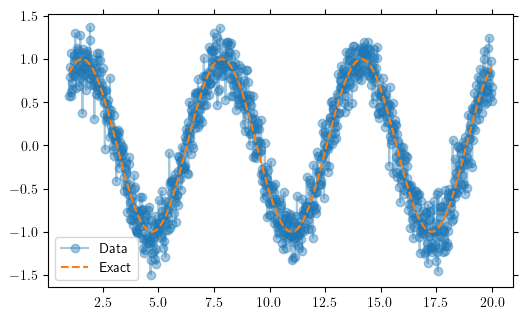

In [21]:
test()